In [1]:
import zipfile
with zipfile.ZipFile("./data/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("./data/archive")

In [2]:
# %pip install scikit-learn

In [3]:
# %pip install pandas

In [4]:
# %pip install opencv-python

In [5]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import os
import cv2
import glob

2023-07-26 20:38:31.019517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 20:38:33.845493: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-07-26 20:38:33.845673: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2023-07-26 20:38:33.853313: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2023-07-26 20:38:36.509232: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 2 compatible adapters.


In [6]:
main_path = "./data/archive/chest_xray"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

In [7]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [8]:
df_test

,class,image
0,Normal,./data/archive/chest_xray/test/NORMAL/IM-0001-...
1,Normal,./data/archive/chest_xray/test/NORMAL/IM-0003-...
2,Normal,./data/archive/chest_xray/test/NORMAL/IM-0005-...
3,Normal,./data/archive/chest_xray/test/NORMAL/IM-0006-...
4,Normal,./data/archive/chest_xray/test/NORMAL/IM-0007-...
...,...,...
619,Pneumonia,./data/archive/chest_xray/test/PNEUMONIA/perso...
620,Pneumonia,./data/archive/chest_xray/test/PNEUMONIA/perso...
621,Pneumonia,./data/archive/chest_xray/test/PNEUMONIA/perso...
622,Pneumonia,./data/archive/chest_xray/test/PNEUMONIA/perso...


Normal


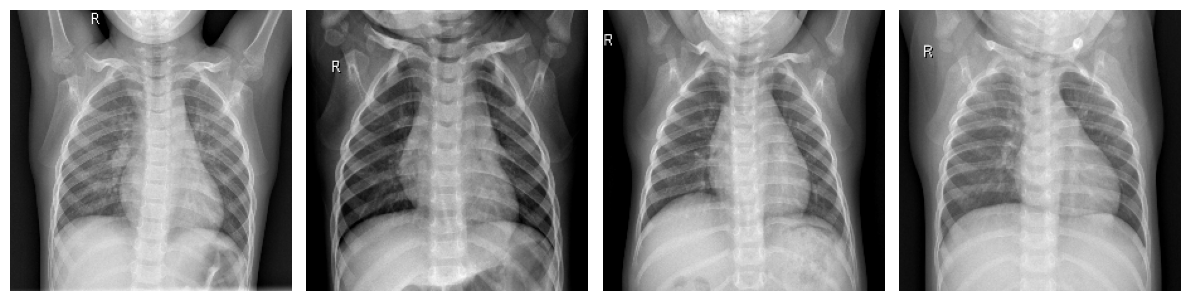

Pneumonia


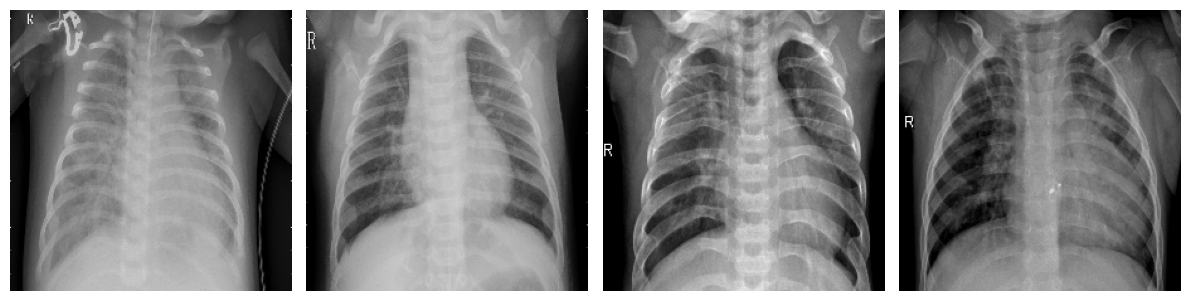

In [9]:
plt.figure(figsize=(12,12))

for i in range(0, 4):
    plt.subplot(3,4,i+1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
print("Normal")
plt.show()

plt.figure(figsize=(12,12))

for i in range(0, 4):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
print("Pneumonia")
plt.show()

In [10]:
train_df, val_df = train_test_split(df_train, test_size = 0.113, random_state = 42, stratify = df_train['class'])

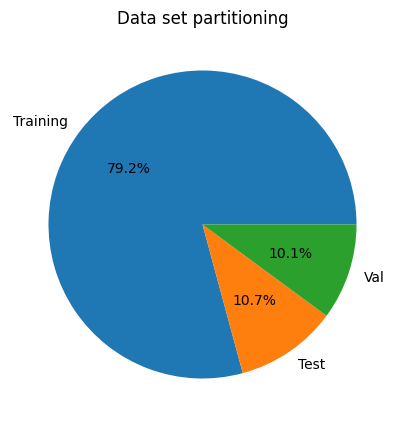

In [11]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(5, 5))
plt.title("Data set partitioning")
counts = [len(train_df),len(df_test),len(val_df)]
labels = ['Training','Test','Val']
plt.pie(counts, labels=labels, autopct="%1.1f%%")
plt.show()

In [12]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                  zoom_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (224, 224),
                                             class_mode = 'binary',
                                             batch_size = 32,
                                             seed = 42)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (224, 224),
                                            class_mode = 'binary',
                                            batch_size = 32,
                                            seed = 42)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (224, 224),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4626 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# second CONV => RELU => CONV => RELU => POOL layer set
model.add(keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

# sigmoid classifier
model.add(keras.layers.Dense(1, activation='sigmoid'))

2023-07-26 20:39:12.886612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 20:39:12.888637: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6700S)
2023-07-26 20:39:14.058438: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 1 (AMD Radeon(TM) Graphics)
2023-07-26 20:39:14.278401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-26 20:39:14.278434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. You

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     888       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 32)     888       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                        

In [16]:
model.fit(ds_train,
          batch_size = 32, epochs = 20,
          validation_data=ds_val,
          steps_per_epoch=(len(train_df)/32),
          validation_steps=(len(val_df)/32));

2023-07-26 20:39:16.131757: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


Epoch 1/20


2023-07-26 20:39:16.992513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-26 20:39:17.156562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-26 20:39:17.156606: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-26 20:39:17.156622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13659 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-07-26 20:39:17.156633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

  4/144 [..............................] - ETA: 1:37 - loss: 1.4064 - accuracy: 0.6406

2023-07-26 20:39:21.215554: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


  5/144 [>.............................] - ETA: 1:37 - loss: 1.3327 - accuracy: 0.6625

2023-07-26 20:39:22.189410: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


  6/144 [>.............................] - ETA: 1:35 - loss: 1.2285 - accuracy: 0.6667

2023-07-26 20:39:22.688596: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


145/144 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8124

2023-07-26 20:40:34.815450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-26 20:40:34.854123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-26 20:40:34.854175: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-26 20:40:34.854193: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13659 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-07-26 20:40:34.854205: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

144/144 [==============================] - 85s 574ms/step - loss: 0.4288 - accuracy: 0.8124 - val_loss: 1.9948 - val_accuracy: 0.7424
Epoch 2/20
144/144 [==============================] - 81s 561ms/step - loss: 0.3142 - accuracy: 0.8725 - val_loss: 0.2064 - val_accuracy: 0.9102
Epoch 3/20
144/144 [==============================] - 82s 569ms/step - loss: 0.2618 - accuracy: 0.8952 - val_loss: 3.5320 - val_accuracy: 0.8373
Epoch 4/20
144/144 [==============================] - 80s 551ms/step - loss: 0.3110 - accuracy: 0.8755 - val_loss: 0.1533 - val_accuracy: 0.9407
Epoch 5/20
144/144 [==============================] - 78s 542ms/step - loss: 0.2778 - accuracy: 0.8911 - val_loss: 0.1529 - val_accuracy: 0.9356
Epoch 6/20
144/144 [==============================] - 78s 537ms/step - loss: 0.2440 - accuracy: 0.8969 - val_loss: 0.1409 - val_accuracy: 0.9407
Epoch 7/20
144/144 [==============================] - 80s 550ms/step - loss: 0.2363 - accuracy: 0.9038 - val_loss: 0.1300 - val_accuracy: 0.9

In [17]:
test_loss, test_accuracy = model.evaluate(ds_test, steps=len(df_test))

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


624/624 [==============================] - 8s 12ms/step - loss: 0.3550 - accuracy: 0.8574
Test Loss: 0.3550
Test Accuracy: 0.8574


In [18]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(ds_test, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict on the test dataset
test_predictions = model.predict(ds_test, verbose=1)
test_predictions = (test_predictions > 0.5).astype(int)

624/624 [==============================] - 7s 12ms/step - loss: 0.3550 - accuracy: 0.8574
Test Loss: 0.3550272285938263
Test Accuracy: 0.8573718070983887
  9/624 [..............................] - ETA: 10s

2023-07-26 21:06:20.147236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


624/624 [==============================] - 7s 12ms/step


2023-07-26 21:06:27.490067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-26 21:06:27.490110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-26 21:06:27.490129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13659 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-07-26 21:06:27.490164: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:1 with 7156 MB memory) -> physical PluggableDevice (device: 1, name: D

In [19]:
# Get the true labels from the test dataset
test_labels = df_test['class'].values

# Create a DataFrame to compare actual vs predicted labels
comparison_df = pd.DataFrame({'Actual': test_labels, 'Predicted': test_predictions.flatten()})

In [20]:
comparison_df

,Actual,Predicted
0,Normal,0
1,Normal,0
2,Normal,0
3,Normal,1
4,Normal,0
...,...,...
619,Pneumonia,1
620,Pneumonia,1
621,Pneumonia,1
622,Pneumonia,1


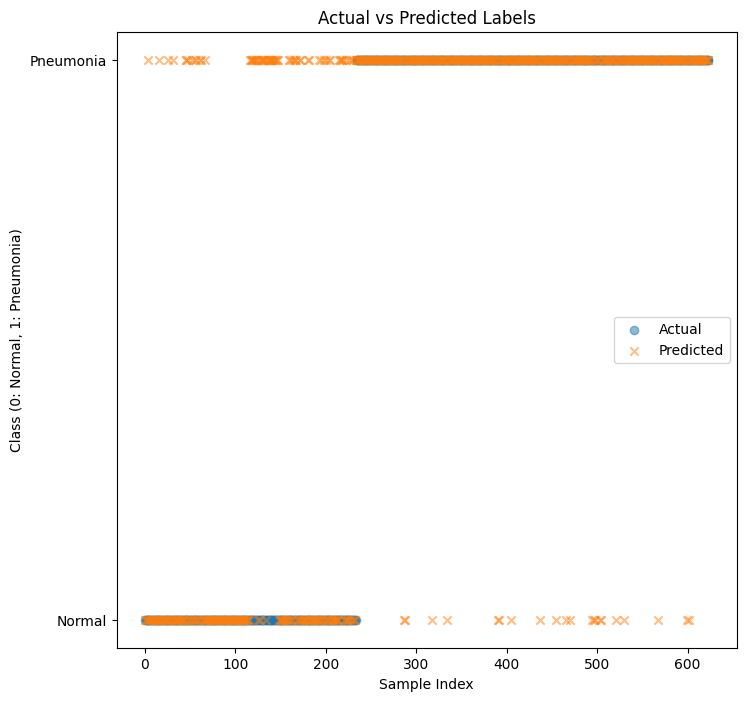

In [21]:
# Flatten the test_predictions array
test_predictions = test_predictions.flatten()

# Visualize the comparison of actual vs predicted labels
plt.figure(figsize=(8, 8))
plt.scatter(range(len(test_labels)), test_labels, marker='o', label='Actual', alpha=0.5)
plt.scatter(range(len(test_predictions)), test_predictions, marker='x', label='Predicted', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Class (0: Normal, 1: Pneumonia)')
plt.legend()
plt.title('Actual vs Predicted Labels')
plt.show()
